In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# ------------------------------
# Utility / Data
# ------------------------------


# Vocabulary: lowercase letters + space
VOCAB = list("abcdefghijklmnopqrstuvwxyz ")
VOCAB_SIZE = len(VOCAB) # 27
CHAR_TO_IDX = {c: i for i, c in enumerate(VOCAB)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}

In [ ]:
def random_text_messages(n_samples=10000, msg_len=8):
    # generate random messages from VOCAB
    arr = np.random.randint(0, VOCAB_SIZE, size=(n_samples, msg_len))
    return arr # shape (n_samples, msg_len)


def one_hot_encode(arr):
    # arr shape: (n_samples, msg_len) ints
    return tf.one_hot(arr, depth=VOCAB_SIZE)

In [ ]:
# Key: random binary vector for each message.
# We'll use a key vector of length equal to message length * key_dim


def random_keys(n_samples=10000, key_len=16):
    # keys are real-valued in [-1,1] to give network flexibility
    return np.random.uniform(-1, 1, size=(n_samples, key_len)).astype(np.float32)


# Convert one-hot predictions back to int messages


def onehot_to_ints(onehot_tensor):
    # expects shape (batch, msg_len, vocab)
    return np.argmax(onehot_tensor, axis=-1)

In [ ]:
# Accuracy per character


def char_accuracy(y_true_ints, y_pred_ints):
    return np.mean(y_true_ints == y_pred_ints)

In [ ]:
# ------------------------------
# Model definitions
# ------------------------------


def build_alice(msg_len, vocab_size, key_len, hidden=256):
    # Alice: takes message one-hot (msg_len*vocab) and key vector -> ciphertext vector
    msg_input = layers.Input(shape=(msg_len, vocab_size), name='alice_msg')
    key_input = layers.Input(shape=(key_len,), name='alice_key')


    x = layers.Flatten()(msg_input)
    x = layers.Concatenate()([x, key_input])
    x = layers.Dense(hidden, activation='relu')(x)
    x = layers.Dense(hidden, activation='relu')(x)
    # output ciphertext vector (we'll produce a vector, which can be split into msg_len * vocab logits)
    out_dim = msg_len * vocab_size
    ciphertext = layers.Dense(out_dim, activation='tanh', name='ciphertext')(x)
    ciphertext = layers.Reshape((msg_len, vocab_size))(ciphertext)


    return models.Model(inputs=[msg_input, key_input], outputs=ciphertext, name='Alice')

In [ ]:
def build_bob(msg_len, vocab_size, key_len, hidden=256):
    # Bob: takes ciphertext and key -> reconstruct message (softmax over vocab for each position)
    ct_input = layers.Input(shape=(msg_len, vocab_size), name='ciphertext')
    key_input = layers.Input(shape=(key_len,), name='bob_key')


    x = layers.Flatten()(ct_input)
    x = layers.Concatenate()([x, key_input])
    x = layers.Dense(hidden, activation='relu')(x)
    x = layers.Dense(hidden, activation='relu')(x)
    out_dim = msg_len * vocab_size
    logits = layers.Dense(out_dim)(x)
    logits = layers.Reshape((msg_len, vocab_size))(logits)
    out = layers.Activation('softmax')(logits)


    return models.Model(inputs=[ct_input, key_input], outputs=out, name='Bob')

In [ ]:
def build_eve(msg_len, vocab_size, hidden=256):
    # Eve: takes ciphertext only -> guess message
    ct_input = layers.Input(shape=(msg_len, vocab_size), name='ciphertext')
    x = layers.Flatten()(ct_input)
    x = layers.Dense(hidden, activation='relu')(x)
    x = layers.Dense(hidden, activation='relu')(x)
    out_dim = msg_len * vocab_size
    logits = layers.Dense(out_dim)(x)
    logits = layers.Reshape((msg_len, vocab_size))(logits)
    out = layers.Activation('softmax')(logits)
    return models.Model(inputs=ct_input, outputs=out, name='Eve')

In [ ]:
# ------------------------------
# Hyperparameters
# ------------------------------
MSG_LEN = 8
KEY_LEN = 32
N_SAMPLES = 20000
BATCH_SIZE = 128
EPOCHS = 30
ALICE_BOB_STEPS = 1 # per batch
EVE_STEPS = 1
LEARNING_RATE = 1e-3
LAMBDA = 1.0 # weight for penalizing Eve in Alice loss (alice_loss = bob_loss - lambda * eve_loss)

In [ ]:
# ------------------------------
# Prepare dataset
# ------------------------------


raw_messages = random_text_messages(N_SAMPLES, MSG_LEN)
X_onehot = one_hot_encode(raw_messages).numpy().astype(np.float32) # shape (N, msg_len, vocab)
K = random_keys(N_SAMPLES, KEY_LEN)


# Train/Val/Test split
X_train, X_temp, K_train, K_temp, y_train, y_temp = train_test_split(
X_onehot, K, raw_messages, test_size=0.3, random_state=42)
X_val, X_test, K_val, K_test, y_val, y_test = train_test_split(
X_temp, K_temp, y_temp, test_size=0.5, random_state=42)


print('Shapes:', X_train.shape, K_train.shape, y_train.shape)

Shapes: (14000, 8, 27) (14000, 32) (14000, 8)


In [ ]:
# ------------------------------
# Build models and optimizers
# ------------------------------


alice = build_alice(MSG_LEN, VOCAB_SIZE, KEY_LEN)
bob = build_bob(MSG_LEN, VOCAB_SIZE, KEY_LEN)
eve = build_eve(MSG_LEN, VOCAB_SIZE)


alice.summary()
bob.summary()
eve.summary()


opt_ab = optimizers.Adam(LEARNING_RATE)
opt_e = optimizers.Adam(LEARNING_RATE)

Model: "Alice"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ alice_msg           │ (None, 8, 27)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 216)       │          0 │ alice_msg[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alice_key           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 248)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ alice_key[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     63,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ciphertext (Dense)  │ (None, 216)       │     55,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 27)     │          0 │ ciphertext[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,048 (722.84 KB)

 Trainable params: 185,048 (722.84 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Bob"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ciphertext          │ (None, 8, 27)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 216)       │          0 │ ciphertext[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bob_key             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 248)       │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ bob_key[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     63,744 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 216)       │     55,512 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 27)     │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8, 27)     │          0 │ reshape_1[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,048 (722.84 KB)

 Trainable params: 185,048 (722.84 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Eve"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ciphertext (InputLayer)         │ (None, 8, 27)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        55,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 216)            │        55,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 27)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 27)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,856 (690.84 KB)

 Trainable params: 176,856 (690.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Loss function: categorical crossentropy per position averaged
cat_loss = losses.CategoricalCrossentropy()


# For logging
history = {'bob_loss': [], 'eve_loss': [], 'alice_loss': [], 'bob_acc': [], 'eve_acc': []}

In [ ]:
# ------------------------------
# Training loop (alternating updates)
# ------------------------------

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, K_train, X_train))  # use one-hot as labels
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, K_val, X_val)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_bob_losses = []
    epoch_eve_losses = []
    epoch_alice_losses = []
    epoch_bob_accs = []
    epoch_eve_accs = []

    for step, (x_batch, k_batch, y_batch) in enumerate(train_dataset):
        # 1) Train Alice+Bob (freeze Eve)
        for _ in range(ALICE_BOB_STEPS):
            with tf.GradientTape() as tape:
                # Alice encrypts
                ct = alice([x_batch, k_batch], training=True)
                # Bob decrypts
                bob_pred = bob([ct, k_batch], training=True)
                # Eve predicts (no gradient for Eve in this step)
                eve_pred = eve(ct, training=False)

                bob_loss = cat_loss(y_batch, bob_pred)
                eve_loss = cat_loss(y_batch, eve_pred)
                alice_loss = bob_loss - LAMBDA * eve_loss

            vars_ab = alice.trainable_variables + bob.trainable_variables
            grads = tape.gradient(alice_loss, vars_ab)
            if grads is not None:
                opt_ab.apply_gradients(zip(grads, vars_ab))

            epoch_bob_losses.append(float(bob_loss.numpy()))
            epoch_eve_losses.append(float(eve_loss.numpy()))
            epoch_alice_losses.append(float(alice_loss.numpy()))

        # 2) Train Eve (freeze Alice+Bob)
        for _ in range(EVE_STEPS):
            with tf.GradientTape() as tape_e:
                ct = alice([x_batch, k_batch], training=False)
                eve_pred = eve(ct, training=True)
                eve_loss_step = cat_loss(y_batch, eve_pred)
            grads_e = tape_e.gradient(eve_loss_step, eve.trainable_variables)
            if grads_e is not None:
                opt_e.apply_gradients(zip(grads_e, eve.trainable_variables))
            epoch_eve_losses.append(float(eve_loss_step.numpy()))

        # Compute accuracies for logging using latest preds
        ct_for_eval = alice([x_batch, k_batch], training=False)
        bob_out = bob([ct_for_eval, k_batch], training=False).numpy()
        eve_out = eve(ct_for_eval, training=False).numpy()

        y_true_ints = onehot_to_ints(y_batch.numpy())
        bob_pred_ints = onehot_to_ints(bob_out)
        eve_pred_ints = onehot_to_ints(eve_out)

        epoch_bob_accs.append(char_accuracy(y_true_ints, bob_pred_ints))
        epoch_eve_accs.append(char_accuracy(y_true_ints, eve_pred_ints))

    # End epoch: compute averages
    h_bob_loss = np.mean(epoch_bob_losses)
    h_eve_loss = np.mean(epoch_eve_losses)
    h_alice_loss = np.mean(epoch_alice_losses) if len(epoch_alice_losses) > 0 else 0
    h_bob_acc = np.mean(epoch_bob_accs)
    h_eve_acc = np.mean(epoch_eve_accs)

    history['bob_loss'].append(h_bob_loss)
    history['eve_loss'].append(h_eve_loss)
    history['alice_loss'].append(h_alice_loss)
    history['bob_acc'].append(h_bob_acc)
    history['eve_acc'].append(h_eve_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} — Bob loss: {h_bob_loss:.4f}, Eve loss: {h_eve_loss:.4f}, Bob acc: {h_bob_acc:.4f}, Eve acc: {h_eve_acc:.4f}")

    # Validation check (optional)
    val_b_accs = []
    val_e_accs = []
    for x_val_b, k_val_b, y_val_b in val_dataset:
        ct_val = alice([x_val_b, k_val_b], training=False)
        bob_v = bob([ct_val, k_val_b], training=False).numpy()
        eve_v = eve(ct_val, training=False).numpy()
        bob_v_int = onehot_to_ints(bob_v)
        eve_v_int = onehot_to_ints(eve_v)
        y_val_ints = onehot_to_ints(y_val_b.numpy())
        val_b_accs.append(char_accuracy(y_val_ints, bob_v_int))
        val_e_accs.append(char_accuracy(y_val_ints, eve_v_int))
    print(f"  Val — Bob acc: {np.mean(val_b_accs):.4f}, Eve acc: {np.mean(val_e_accs):.4f}")

Epoch 1/30 — Bob loss: 2.8096, Eve loss: 3.1921, Bob acc: 0.2181, Eve acc: 0.0907
  Val — Bob acc: 0.4585, Eve acc: 0.1945
Epoch 2/30 — Bob loss: 1.5133, Eve loss: 2.7919, Bob acc: 0.5914, Eve acc: 0.2181
  Val — Bob acc: 0.6208, Eve acc: 0.2161
Epoch 3/30 — Bob loss: 1.1688, Eve loss: 2.6671, Bob acc: 0.6903, Eve acc: 0.2465
  Val — Bob acc: 0.6532, Eve acc: 0.2405
Epoch 4/30 — Bob loss: 1.0279, Eve loss: 2.6039, Bob acc: 0.7324, Eve acc: 0.2586
  Val — Bob acc: 0.6920, Eve acc: 0.2528
Epoch 5/30 — Bob loss: 0.9315, Eve loss: 2.5612, Bob acc: 0.7590, Eve acc: 0.2665
  Val — Bob acc: 0.7102, Eve acc: 0.2643
Epoch 6/30 — Bob loss: 0.8791, Eve loss: 2.5465, Bob acc: 0.7689, Eve acc: 0.2704
  Val — Bob acc: 0.7184, Eve acc: 0.2466
Epoch 7/30 — Bob loss: 0.8247, Eve loss: 2.6194, Bob acc: 0.7842, Eve acc: 0.2499
  Val — Bob acc: 0.7306, Eve acc: 0.2311
Epoch 8/30 — Bob loss: 0.7754, Eve loss: 2.6209, Bob acc: 0.7957, Eve acc: 0.2490
  Val — Bob acc: 0.7413, Eve acc: 0.2365
Epoch 9/30 — Bob

In [ ]:
# ------------------------------
# Final evaluation on test set
# ------------------------------

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, K_test, y_test)).batch(BATCH_SIZE)
all_b_accs = []
all_e_accs = []
for x_t, k_t, y_t in test_dataset:
    ct_t = alice([x_t, k_t], training=False)
    bob_t = bob([ct_t, k_t], training=False).numpy()
    eve_t = eve(ct_t, training=False).numpy()
    all_b_accs.append(char_accuracy(y_t.numpy(), onehot_to_ints(bob_t)))
    all_e_accs.append(char_accuracy(y_t.numpy(), onehot_to_ints(eve_t)))

print('\nFinal Test Results:')
print('Bob accuracy (per character):', np.mean(all_b_accs))
print('Eve accuracy (per character):', np.mean(all_e_accs))


Final Test Results:
Bob accuracy (per character): 0.8938976469494048
Eve accuracy (per character): 0.1385498046875


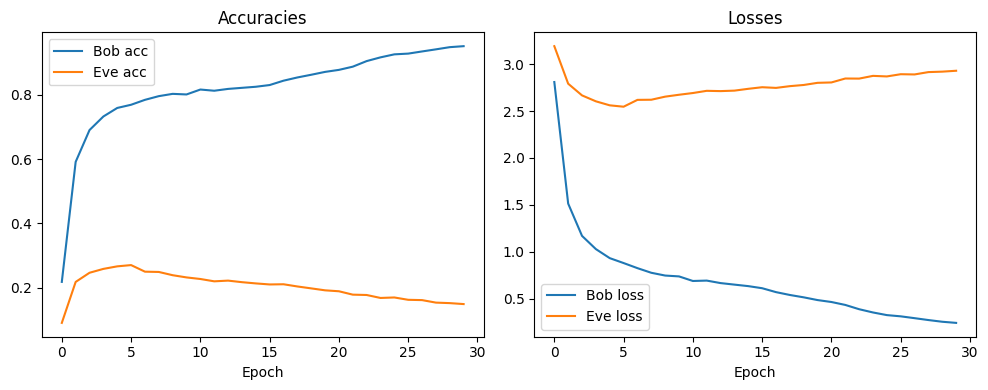

In [ ]:
# ------------------------------
# Plots
# ------------------------------

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['bob_acc'], label='Bob acc')
plt.plot(history['eve_acc'], label='Eve acc')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['bob_loss'], label='Bob loss')
plt.plot(history['eve_loss'], label='Eve loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------
# Example test case: visualize Alice->Bob/Eve
# ------------------------------

def ints_to_text(int_arr):
    return ''.join([IDX_TO_CHAR[i] for i in int_arr])

# Take one random test sample
idx = np.random.randint(0, len(X_test))
msg_true_onehot = X_test[idx:idx+1]
msg_true_ints = onehot_to_ints(msg_true_onehot)
msg_text = ints_to_text(msg_true_ints[0])

key_true = K_test[idx:idx+1]

# Alice encrypts
ct = alice([msg_true_onehot, key_true], training=False).numpy()
# Bob decrypts
bob_out = bob([ct, key_true], training=False).numpy()
# Eve tries
eve_out = eve(ct, training=False).numpy()

bob_ints = onehot_to_ints(bob_out)
eve_ints = onehot_to_ints(eve_out)

bob_text = ints_to_text(bob_ints[0])
eve_text = ints_to_text(eve_ints[0])

print("Original message (Alice input):", msg_text)
print("Ciphertext (Alice output, rounded):\n", np.round(ct[0], 2))
print("Bob's decrypted message:", bob_text)
print("Eve's guessed message:", eve_text)

Original message (Alice input): fqlkmlty
Ciphertext (Alice output, rounded):
 [[ 0.19 -0.48  0.98  0.16 -0.61 -0.52 -0.45 -0.08  0.53  0.39  0.28  0.68
  -0.95  0.96 -0.76 -0.89  0.76  0.39  0.63 -0.36 -0.06  0.79 -0.05  0.78
  -0.65  0.17 -0.19]
 [ 0.89  1.   -0.98  0.58 -0.    0.45  0.24 -0.82  0.73 -0.95  0.41 -0.55
   0.45 -0.35 -0.73  0.74 -0.5   0.9   0.14  0.05  0.95  0.97 -0.48 -0.49
  -0.8  -0.96 -0.67]
 [-0.94 -0.4   0.22  0.43 -0.1  -0.71  0.24 -0.38  0.56  0.45 -0.3   0.72
   0.85  0.12 -0.2  -0.93 -0.58 -0.4  -0.03 -0.65  0.72  0.78  0.67  0.12
  -0.95  0.04 -0.94]
 [ 0.46 -1.   -0.93  0.93 -0.31 -0.87  0.5   0.15  0.39  0.23 -0.29  0.69
  -0.09  0.44 -0.7  -0.03 -0.27  0.97 -0.27  0.32  0.03  0.31  0.97  0.25
   0.89 -0.94 -0.96]
 [ 0.29 -0.38  0.56 -0.83 -0.26 -0.23  0.83  0.87 -0.39  0.07 -0.89  0.38
   0.35  0.94  0.92 -0.04 -0.42 -0.39 -0.38  0.89  0.9  -0.15  0.13 -0.57
   0.91 -0.84 -0.93]
 [-0.37 -0.98  0.51  0.94  0.85 -0.11 -0.38 -0.12 -0.07 -0.23  0.95 -0.22
  -

In [ ]:
# ------------------------------
# Save models
# ------------------------------

os.makedirs('saved_models', exist_ok=True)
alice.save('saved_models/alice.h5')
bob.save('saved_models/bob.h5')
eve.save('saved_models/eve.h5')

print('Models saved to ./saved_models')


Models saved to ./saved_models
